C:\Users\Newt\AppData\Local\Temp\ipykernel_21096\1065596989.py:1: DeprecationWarning: The ``qiskit.opflow`` module is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/opflow_migration.
  from qiskit.opflow import Z
C:\Users\Newt\AppData\Local\Temp\ipykernel_21096\1065596989.py:2: DeprecationWarning: ``qiskit.algorithms`` has been migrated to an independent package: https://github.com/qiskit-community/qiskit-algorithms. The ``qiskit.algorithms`` import path is deprecated as of qiskit-terra 0.25.0 and will be removed no earlier than 3 months after the release date. Please run ``pip install qiskit_algorithms`` and use ``import qiskit_algorithms`` instead.
  from qiskit.algorithms import QAOA
C:\Users\Newt\AppData\Local\Temp\ipykernel_21096\1065596989.py:4: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.qaoa.QAOA`` is deprecated as of qiskit-terra 0.24.0. I

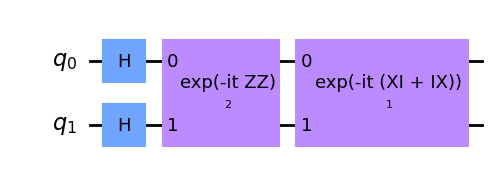

In [1]:
from qiskit.opflow import Z
from qiskit.algorithms import QAOA
H1 = Z^Z # Define Z_0Z_1
qaoa = QAOA()
circuit = qaoa.construct_circuit([1,2],H1)[0]
circuit.draw(output="mpl")

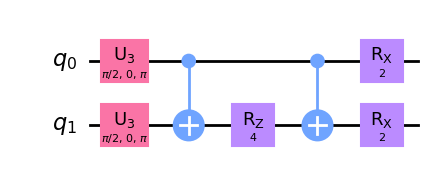

In [2]:
circuit.decompose().decompose().draw(output="mpl")

C:\Users\Newt\AppData\Local\Temp\ipykernel_21096\893502146.py:1: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.qaoa.QAOA`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.QAOA``. See https://qisk.it/algo_migration for a migration guide.
  qaoa = QAOA(reps = 2)


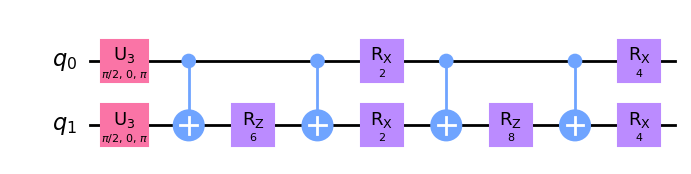

In [3]:
qaoa = QAOA(reps = 2)
circuit = qaoa.construct_circuit([1,2,3,4],H1)[0]
circuit.decompose().decompose().draw(output="mpl")

In [4]:
from qiskit.utils import algorithm_globals, QuantumInstance
from qiskit import Aer
from qiskit.algorithms.optimizers import COBYLA
seed = 1234
algorithm_globals.random_seed = seed
quantum_instance = QuantumInstance(Aer.get_backend("aer_simulator"),
seed_simulator=seed, seed_transpiler=seed,
shots = 10)
qaoa = QAOA(optimizer = COBYLA(), quantum_instance=quantum_instance)
result = qaoa.compute_minimum_eigenvalue(H1)
print(result)

C:\Users\Newt\AppData\Local\Temp\ipykernel_21096\1317724831.py:6: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(Aer.get_backend("aer_simulator"),


{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 20,
    'eigenstate': {'01': 0.5477225575051661, '10': 0.8366600265340756},
    'eigenvalue': (-1+0j),
    'optimal_circuit': None,
    'optimal_parameters': {   ParameterVectorElement(β[0]): 6.7647519845416655,
                              ParameterVectorElement(γ[0]): -0.847240391875931},
    'optimal_point': array([ 6.76475198, -0.84724039]),
    'optimal_value': -1.0,
    'optimizer_evals': None,
    'optimizer_result': None,
    'optimizer_time': 0.06369590759277344}


C:\Users\Newt\AppData\Local\Temp\ipykernel_21096\1317724831.py:9: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.qaoa.QAOA`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.QAOA``. See https://qisk.it/algo_migration for a migration guide.
  qaoa = QAOA(optimizer = COBYLA(), quantum_instance=quantum_instance)


In [12]:
My_token = 'c9f9e73ead2cd8e4a404105185a3abd681a91e9012bd5c77cfd4c07bcd265c32c7f7ff67d0d2a374ecdbf7c70a22f4482868ba92212d09900928adcaba224090' # Paste your token here
from qiskit import IBMQ
IBMQ.save_account(My_token, overwrite=True)

In [18]:
from qiskit import IBMQ
provider = IBMQ.load_account()
program_id = "qaoa"
H1 = Z^Z
opt = COBYLA()
reps = 1
shots = 1024
runtime_inputs = {
"operator": H1,
"reps": reps,
"optimizer": opt,
"initial_point": [0,0],
"use_swap_strategies": False
}
options = {"backend_name": "ibmq_belem"}
#job = provider.runtime.run(program_id=program_id, options=options, inputs=runtime_inputs)
job = provider.runtime.job(program_id)

ibmqfactory.load_account:WARNING:2023-11-01 16:12:02,201: Credentials are already in use. The existing account in the session will be replaced.


RuntimeJobNotFound: 'Job not found: 404 Client Error: Not Found for url: https://api.quantum-computing.ibm.com/runtime/jobs/qaoa. {"errors":[{"code":1291,"message":"Job not found. Job ID: qaoa","solution":"Verify the job ID is correct, and that you have the correct access permissions.","more_info":"https://cloud.ibm.com/apidocs/quantum-computing#error-handling"}],"trace":"cl10glvjcqd1hlcqbgi0"}'